# Notebook Setup

In [1]:
!apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
%pip install -U tf-agents pyvirtualdisplay
%pip install -U gym>=0.21.0
%pip install -U gym[box2d,atari,accept-rom-license]

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [2,227 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [2,898 kB]
Ign:13 https://developer.download.nvidia.com/compute/machine-le

In [2]:
# Import Libraries

# TensorFlow
import tensorflow as tf
from tensorflow import keras

# Maths
import numpy as np
import matplotlib.pyplot as plt

# Gym
import gym

# Virtual Display
import pyvirtualdisplay

# Common
import os
import sys

# Other
from collections import deque

/usr/local/lib/python3.7/dist-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [3]:
# Global Variables
PROJECT_ROOT_DIR = 'drive/MyDrive/ML/Keras_Version'

# SEEDS
np.random.seed(69)
tf.random.set_seed(420)

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Helper Functions

In [277]:
# Pre-Processing
def preprocess_observation(observation):

    # Slice Top Off
    img = observation[14:210:2, ::2]

    # Grey Scale
    img = img.mean(axis=2)
    img = (img - 128).astype(np.float32)

    return img.reshape(98, 80, 1)

In [293]:
# Epsilon Greedy Policy
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict_step(np.array([state]))
        return np.argmax(Q_values[0])

In [299]:
# Sample Experiences
def sample_experiences(batch_size):
    indices = np.random.randint(len(REPLAY_MEMORY), size=batch_size)
    batch = [REPLAY_MEMORY[index] for index in indices]
    states, actions, rewards, next_states, dones = [np.array([experience[field_index] for experience in batch]) for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [121]:
# Play One Step
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    next_state = preprocess_observation(next_state)
    REPLAY_MEMORY.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [308]:
# Config
batch_size = 50
discount_rate = 0.99
learning_rate = 1e-2

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values).reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis = 1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

# Q-Learning with Frames

In [297]:
# Create Environment
keras.backend.clear_session()

env = gym.make("Assault-v0")
input_shape = (98, 80, 1)
n_outputs = env.action_space.n

# Create Model
model = keras.models.Sequential([
                               keras.layers.Conv2D(filters=32, kernel_size=8, activation="relu", input_shape=input_shape),
                               keras.layers.Conv2D(filters=16, kernel_size=4, activation="relu"),
                               keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                               keras.layers.Flatten(),
                               keras.layers.Dense(n_outputs, activation="relu")
])

# model.summary()

In [311]:
# Train Convolutional Model

# CONFIG
env.seed(710)
REPLAY_MEMORY = deque(maxlen=100)
EPISODES = 1000
WARMUP = 35


episode_rewards = []
best_score = 0
step = 0

for episode in range(EPISODES):
    
    obs = preprocess_observation(env.reset())
    
    episode_rewards.append(0)
    while True:
        step += 1
        epsilon = max(1 - episode / EPISODES, 0.01)
        
        obs, reward, done, info = play_one_step(env, obs, epsilon)

        episode_rewards[episode] += reward

        if done:
            break

    print("\rEpisode: {}, Steps: {}, eps: {:.3f}, current_reward: {}".format(episode, step + 1, epsilon, episode_rewards[episode]), end="")
    
    # if episode > WARMUP:
    training_step(batch_size)

Episode: 32, Steps: 25787, eps: 0.968, current_reward: 315.0

KeyboardInterrupt: ignored

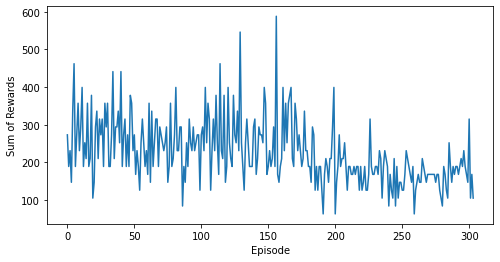

In [307]:
# Plot Results
plt.figure(figsize=(8, 4))
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of Rewards")
plt.show()